Imports

In [1]:
#imports
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback, set_seed
from datasets import Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

# Import our modules
import sys
import os

utils_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'utils'))
models_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'models'))

if utils_path not in sys.path:
    sys.path.insert(0, utils_path)
if models_path not in sys.path:
    sys.path.insert(0, models_path)

from general_utils import load_data, prepare_all_samples, get_entity_date_pairs, calculate_metrics
from bert_training_utils import create_training_pairs, handle_class_imbalance, add_special_tokens, tokenize_function, compute_metrics, build_gold_lookup, get_label_for_pair
from bert_extractor_utils import preprocess_input, bert_extraction, mark_entities_full_text
from bert_model import BertRC

Data Loading

In [ ]:
# Load data
df = load_data("../data/training_dataset_synthetic.csv")
print(f"Loaded {len(df)} records")

Loaded 101 records


In [3]:
#Inspect df
df.head()

,doc_id,note_text,entities_json,dates_json,relations_json
0,0,Ultrasound (30nd Jun 2024): no significant fin...,"[{'id': 300001, 'value': 'asthma', 'cui': 'pla...","[{'id': 308001, 'value': '02nd Aug 2024', 'sta...","[{'date': '02nd Aug 2024', 'entity': 'asthma',..."
1,1,Labs (27th Sep 2024): anemia. resolving Skin:...,"[{'id': 300001, 'value': 'multiple_sclerosis',...","[{'id': 308001, 'value': '27th Sep 2024', 'sta...","[{'date': '27th Sep 2024', 'entity': 'multiple..."
2,2,URGENT REVIEW (2024-10-04): cough. suspect ost...,"[{'id': 300001, 'value': 'osteoarthritis', 'cu...","[{'id': 308001, 'value': '2024-10-04', 'start'...","[{'date': '07.05.25', 'entity': 'copd', 'date_..."
3,3,URGENT REVIEW (13rd Feb 2025) MRI of the brain...,"[{'id': 300001, 'value': 'schizophrenia', 'cui...","[{'id': 308001, 'value': '13rd Feb 2025', 'sta...","[{'date': '13rd Feb 2025', 'entity': 'schizoph..."
4,4,New pt((18/11/24)): pt presents with nausea/vo...,"[{'id': 300001, 'value': 'diabetes_mellitus', ...","[{'id': 308001, 'value': '18/11/24', 'start': ...","[{'date': '18/11/24', 'entity': 'diabetes_mell..."


In [4]:
# Prepare all samples
samples = prepare_all_samples(df)
print(f"Prepared {len(samples)} samples")
#samples[0]

Prepared 101 samples


Model & Data Preparation for Finetuning

In [5]:
# Set seed for reproducibility
set_seed(42)

In [6]:
#Set path to save model
model_save_path = '../models/bert_models/'

In [7]:
#Choose model to use - any BERT model from HuggingFace can be used, see: https://huggingface.co/google-bert

model_name = "google/bert_uncased_L-2_H-128_A-2"
#model_name = "google-bert/bert-base-uncased"

In [8]:
# Create training pairs
processed_df = create_training_pairs(samples)
print(f"\nCreated {len(processed_df)} training pairs")


Created 1242 training pairs


In [9]:
# Handle class imbalance
balanced_df, class_weights = handle_class_imbalance(processed_df, method='weighted')
print(f"Class weights: {class_weights}")

print("\nAfter balancing:")
print(balanced_df['label'].value_counts())

Class weights: tensor([0.2818, 1.7182])

After balancing:
label
0    1067
1     175
Name: count, dtype: int64


In [10]:
# Train-test split
train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42, stratify=balanced_df['label'])
print(f"Train: {len(train_df)}, Test: {len(test_df)}")

print("\nTrain set distribution:")
print(train_df['label'].value_counts())
print("\nTest set distribution:") 
print(test_df['label'].value_counts())

Train: 993, Test: 249

Train set distribution:
label
0    853
1    140
Name: count, dtype: int64

Test set distribution:
label
0    214
1     35
Name: count, dtype: int64


In [11]:
# Setup tokenizer with special tokens
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer = add_special_tokens(tokenizer)

In [12]:
# Prepare PyTorch datasets
train_dataset = Dataset.from_pandas(train_df[['marked_text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['marked_text', 'label']])

In [13]:
# Tokenize
train_tokenized = train_dataset.map(lambda x: tokenize_function(x, tokenizer, max_length=256), batched=True)
test_tokenized = test_dataset.map(lambda x: tokenize_function(x, tokenizer, max_length=256), batched=True)

Map:   0%|          | 0/993 [00:00<?, ? examples/s]

Map:   0%|          | 0/249 [00:00<?, ? examples/s]

In [14]:
# Set format for PyTorch
train_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

BERT Finetuning

In [15]:
# Create custom model with span pooling
# Note embeddings are re-sized within bert_model.py so doesn't need to be manually done here
model = BertRC(
    model_name=model_name,
    tokenizer=tokenizer,
    num_labels=2,
    class_weights=class_weights
)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [16]:
#Or alternatively use the BERT model as is - note you should only use one of these options
#model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
#model.resize_token_embeddings(len(tokenizer))

In [17]:
#Confirm model type
type(model)

bert_model.BertRC

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir=model_save_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_strategy="steps",
    logging_steps=50,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_ratio=0.1,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    report_to=[],
    seed=42,
)

In [19]:
# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

C:\Users\Satyam\AppData\Local\Temp\ipykernel_2948\1607247895.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [20]:
#Train
trainer.train()

c:\Users\Satyam\Downloads\pituitary_adenoma\venv\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Micro,F1 Weighted
1,0.680900,0.722290,0.775100,0.510943,0.775100,0.769326
2,0.659000,0.708885,0.714859,0.538226,0.714859,0.743534
3,0.653700,0.713692,0.746988,0.544578,0.746988,0.762839
4,0.675900,0.704223,0.670683,0.515242,0.670683,0.712575
5,0.647500,0.728406,0.775100,0.545383,0.775100,0.777696
6,0.656600,0.714558,0.726908,0.530710,0.726908,0.748843
7,0.642400,0.723287,0.742972,0.532833,0.742972,0.758072
8,0.619500,0.725844,0.730924,0.541688,0.730924,0.753395
9,0.585400,0.723731,0.718876,0.555357,0.718876,0.749197
10,0.593300,0.724036,0.718876,0.555357,0.718876,0.749197


c:\Users\Satyam\Downloads\pituitary_adenoma\venv\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\Satyam\Downloads\pituitary_adenoma\venv\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\Satyam\Downloads\pituitary_adenoma\venv\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\Satyam\Downloads\pituitary_adenoma\venv\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\U

TrainOutput(global_step=1250, training_loss=0.6338480621337891, metrics={'train_runtime': 366.5002, 'train_samples_per_second': 27.094, 'train_steps_per_second': 3.411, 'total_flos': 0.0, 'train_loss': 0.6338480621337891, 'epoch': 10.0})

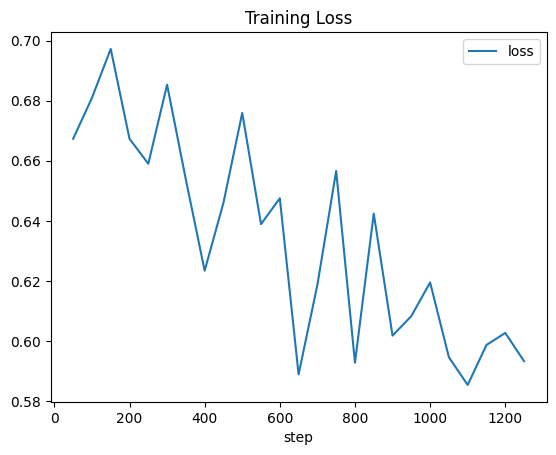

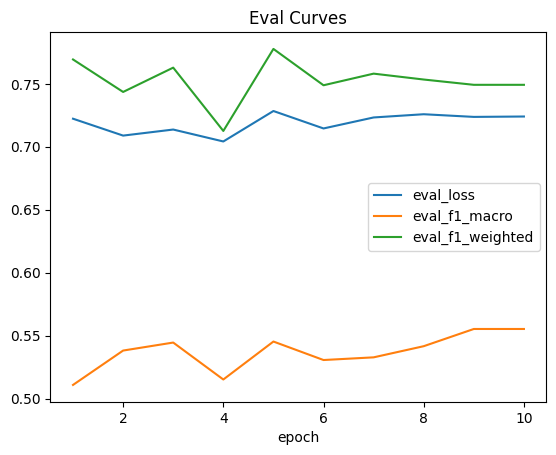

In [21]:
#Loss and training curves
logs = pd.DataFrame(trainer.state.log_history)

# Training loss per step
train_loss = logs[logs.loss.notna()][["step","loss"]]
train_loss.plot(x="step", y="loss", title="Training Loss"); plt.show()

# Eval loss/metrics per eval
eval_logs = logs[logs.eval_loss.notna()][["epoch","eval_loss","eval_accuracy","eval_f1_macro","eval_f1_weighted"]]
eval_logs.plot(x="epoch", y=["eval_loss","eval_f1_macro","eval_f1_weighted"], title="Eval Curves"); plt.show()

In [22]:
# Evaluate on test set
eval_results = trainer.evaluate(test_tokenized)
print("\nTest Results:")
for metric, value in eval_results.items():
    if not metric.startswith('eval_'):
        continue
    clean_metric = metric.replace('eval_', '')
    print(f"{clean_metric}: {value:.4f}")

c:\Users\Satyam\Downloads\pituitary_adenoma\venv\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Test Results:
loss: 0.7237
accuracy: 0.7189
f1_macro: 0.5554
f1_micro: 0.7189
f1_weighted: 0.7492
runtime: 1.2062
samples_per_second: 206.4350
steps_per_second: 13.2650


In [23]:
# Save the final model
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"\nModel saved to {model_save_path}")


Model saved to ../models/bert_models/
